# Création d'une architecture à deux modèles : Détection + Diagnostic

## Modèle 1 : Détecteur d’anomalies (non supervisé)
Objectif : Alerter sur un comportement anormal (sans préciser la cause)
Données : Dataset avec & sans anomalies 
Méthodes : Autoencodeur 
Sortie : Score d’anomalie

### 1 - Import des bibliothèques et chargement des données

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Charger les données
filepath = '../raw_data/TEP_FaultFree_Training.csv'
# filepath = '../raw_data/TEP_Faulty_Training.csv'
data = pd.read_csv(filepath)

# Noms des colonnes
column_names = [
    'faultNumber', 'simulationRun', 'sample',
    *[f'xmeas_{i}' for i in range(1, 42)],
    *[f'xmv_{i}' for i in range(1, 12)]
]
data.columns = column_names

# Afficher les premières lignes
data.head()


,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0,1,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0,1,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0,1,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0,1,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0,1,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461


## Conversion des Dtypes

In [3]:
cols_to_convert = [col for col in data.columns if col.startswith(('fault', 'simul', 'samp'))]
data[cols_to_convert] = data[cols_to_convert].astype('int16')

cols_to_convert = [col for col in data.columns if col.startswith(('xmeas', 'xmv'))]
data[cols_to_convert] = data[cols_to_convert].astype('float32')

In [4]:
# Afficher un résumé des données
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 55 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   faultNumber    250000 non-null  int16  
 1   simulationRun  250000 non-null  int16  
 2   sample         250000 non-null  int16  
 3   xmeas_1        250000 non-null  float32
 4   xmeas_2        250000 non-null  float32
 5   xmeas_3        250000 non-null  float32
 6   xmeas_4        250000 non-null  float32
 7   xmeas_5        250000 non-null  float32
 8   xmeas_6        250000 non-null  float32
 9   xmeas_7        250000 non-null  float32
 10  xmeas_8        250000 non-null  float32
 11  xmeas_9        250000 non-null  float32
 12  xmeas_10       250000 non-null  float32
 13  xmeas_11       250000 non-null  float32
 14  xmeas_12       250000 non-null  float32
 15  xmeas_13       250000 non-null  float32
 16  xmeas_14       250000 non-null  float32
 17  xmeas_15       250000 non-nul

## 2 - Nettoyage et normalisation

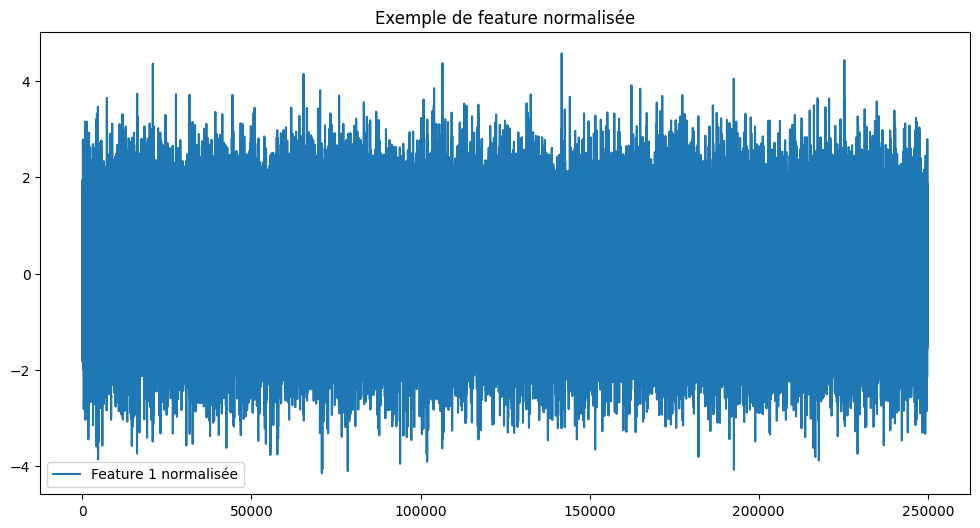

In [5]:
# Convertir en numérique
data = data.apply(pd.to_numeric, errors='coerce')

# Sélectionner les colonnes de mesures
measure_columns = data.columns[3:]  # Ignorer `faultNumber`, `simulationRun`, `sample`
X = data[measure_columns].values

# Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Visualiser une feature normalisée
plt.figure(figsize=(12, 6))
plt.plot(X_scaled[:, 0], label='Feature 1 normalisée')
plt.title('Exemple de feature normalisée')
plt.legend()
plt.show()


## 3 - Fenêtrage temporel par simulationRun

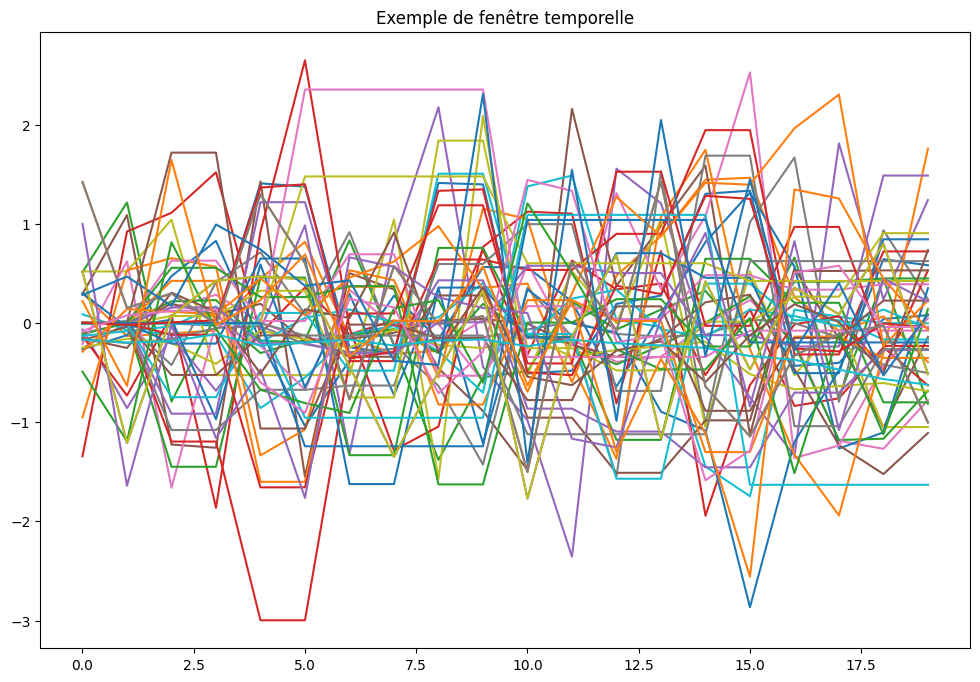

Forme des fenêtres : (48000, 20, 52)


In [9]:
# Fonction pour créer des fenêtres
def create_windows_per_run(data, simulation_runs, n_timesteps=20, stride=5):
    windows = []
    for run in np.unique(simulation_runs):
        run_data = data[simulation_runs == run]
        generator = TimeseriesGenerator(
            run_data, run_data,
            length=n_timesteps,
            stride=stride,
            batch_size=1
        )
        for window, _ in generator:
            windows.append(window[0])
    return np.array(windows)

# Créer les fenêtres
X_windowed = create_windows_per_run(X_scaled, data['simulationRun'])

# Visualiser une fenêtre
plt.figure(figsize=(12, 8))
plt.plot(X_windowed[0], label='Fenêtre temporelle (20 pas de temps)')
plt.title('Exemple de fenêtre temporelle')
#plt.legend()
plt.show()

# Afficher la forme des données
print(f"Forme des fenêtres : {X_windowed.shape}")


## 4 - Validation des données

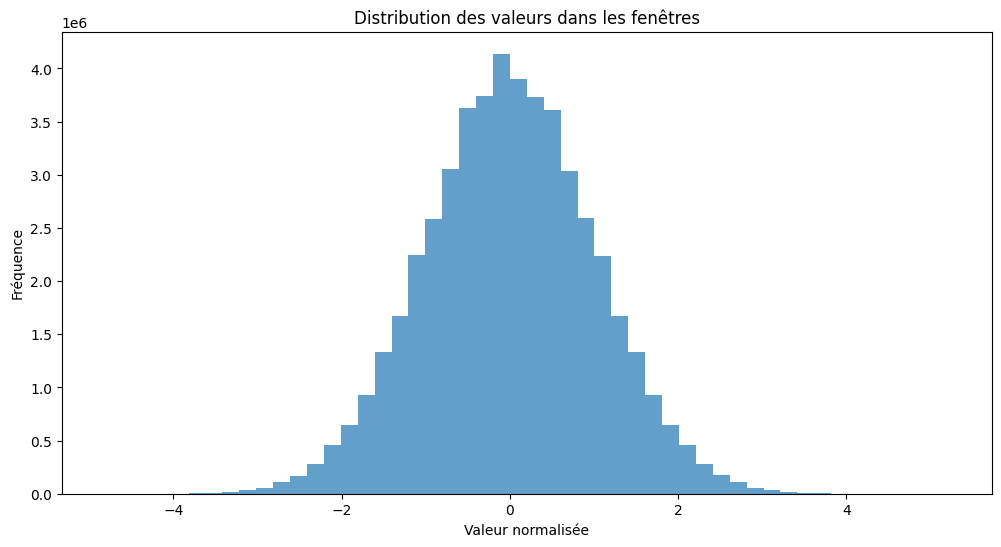

In [10]:
# Vérifier la distribution des données
plt.figure(figsize=(12, 6))
plt.hist(X_windowed.flatten(), bins=50, alpha=0.7)
plt.title('Distribution des valeurs dans les fenêtres')
plt.xlabel('Valeur normalisée')
plt.ylabel('Fréquence')
plt.show()


## Architecture du modèle

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed

model = Sequential([
    LSTM(64, activation='tanh', input_shape=(X_windowed.shape[1], X_windowed.shape[2])),
    RepeatVector(X_windowed.shape[1]),
    LSTM(64, activation='tanh', return_sequences=True),
    TimeDistributed(Dense(X_windowed.shape[2]))
])
model.compile(optimizer='adam', loss='mse')
model.summary()


/Users/julien/.pyenv/versions/3.10.6/envs/monitor-the-reactor/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        29,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 20, 52)         │         3,380 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,356 (259.20 KB)

 Trainable params: 66,356 (259.20 KB)

 Non-trainable params: 0 (0.00 B)

## Entraînement

Epoch 1/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.6883 - val_loss: 0.6268
Epoch 2/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.6041 - val_loss: 0.5911
Epoch 3/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.5801 - val_loss: 0.5741
Epoch 4/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.5674 - val_loss: 0.5638
Epoch 5/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.5590 - val_loss: 0.5566
Epoch 6/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.5519 - val_loss: 0.5499
Epoch 7/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.5461 - val_loss: 0.5448
Epoch 8/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.5418 - val_loss: 0.5412
Epoch 9/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.5387 - val_loss: 0.5385
Epoch 10/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.5365 - val_loss: 0.5376
Epoch 11/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.5345 - val_loss: 0.5351
Epoch 12/50
1350/1350 ━━━━━━━

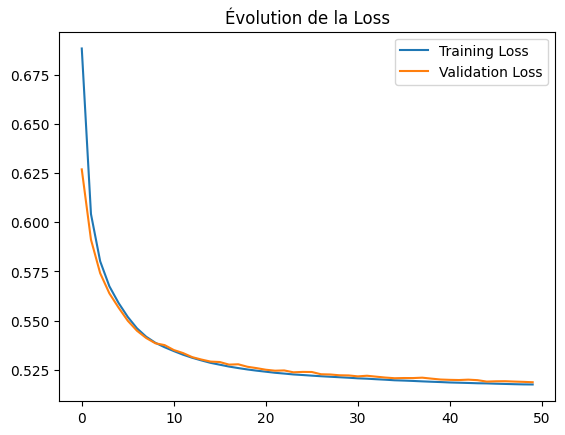

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

# Callback pour arrêter l'entraînement si la loss ne s'améliore plus
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entraînement
history = model.fit(
    X_windowed, X_windowed,  # Autoencodeur : entrée = sortie
    epochs=50,
    batch_size=32,
    validation_split=0.1,     # 10% des données pour la validation
    callbacks=[early_stopping],
    shuffle=True
)

# Visualisation de la loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Évolution de la Loss')
plt.show()


 Calcul des Scores d'Anomalies

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


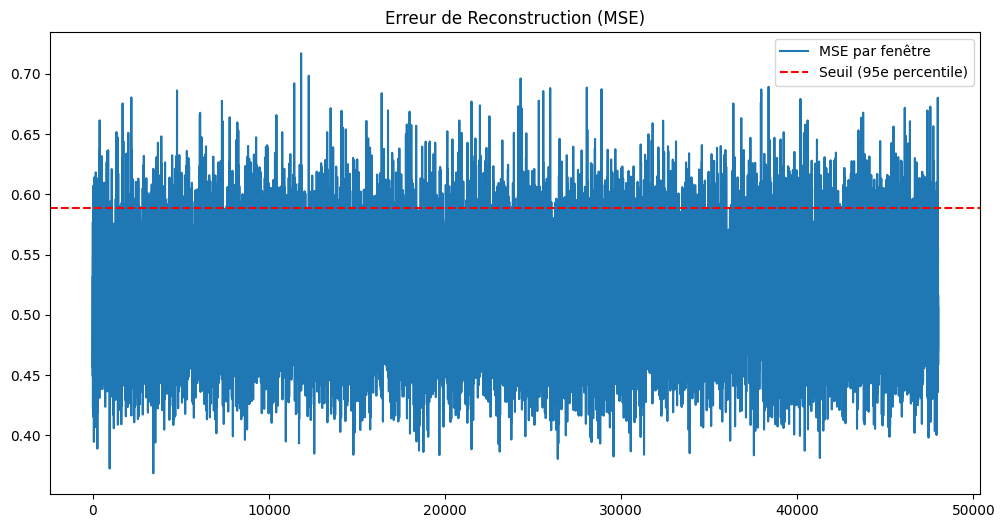

Seuil de détection : 0.5883837938308716


In [13]:
# Prédiction sur les données d'entraînement
X_pred = model.predict(X_windowed)

# Calcul de l'erreur de reconstruction (MSE)
mse = np.mean(np.square(X_windowed - X_pred), axis=(1, 2))

# Visualisation de l'erreur
plt.figure(figsize=(12, 6))
plt.plot(mse, label='MSE par fenêtre')
plt.axhline(y=np.percentile(mse, 95), color='r', linestyle='--', label='Seuil (95e percentile)')
plt.title('Erreur de Reconstruction (MSE)')
plt.legend()
plt.show()

# Seuil pour détecter les anomalies
threshold = np.percentile(mse, 95)
print(f"Seuil de détection : {threshold}")


Évaluation de la Pertinence

In [16]:
# Supposons que tu as un fichier similaire avec des anomalies
test_data = pd.read_csv('../raw_data/TEP_Faulty_Training.csv')
test_data.columns = column_names  # Même noms de colonnes que précédemment

# Préparation des données (même pipeline que pour l'entraînement)
X_test = test_data[measure_columns].values
X_test_scaled = scaler.transform(X_test)  # Utilise le même scaler que pour l'entraînement

# Fenêtrage
X_test_windowed = create_windows_per_run(X_test_scaled, test_data['simulationRun'])


Prédiction et détection des anomalies

31188/31188 ━━━━━━━━━━━━━━━━━━━━ 69s 2ms/step


/Users/julien/.pyenv/versions/3.10.6/envs/monitor-the-reactor/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


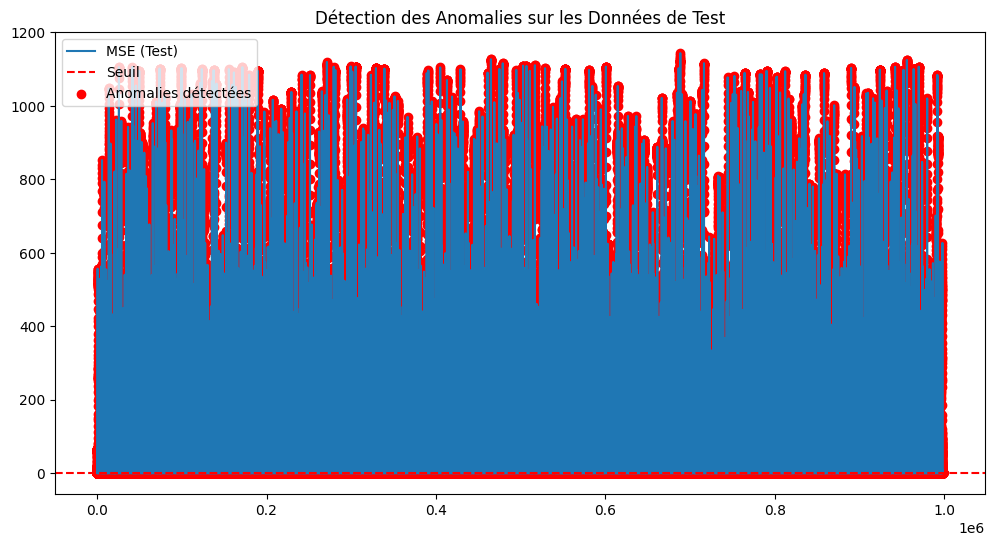

In [17]:
# Prédiction sur les données de test
X_test_pred = model.predict(X_test_windowed)

# Calcul de l'erreur de reconstruction
mse_test = np.mean(np.square(X_test_windowed - X_test_pred), axis=(1, 2))

# Détection des anomalies
anomalies = mse_test > threshold

# Visualisation
plt.figure(figsize=(12, 6))
plt.plot(mse_test, label='MSE (Test)')
plt.axhline(y=threshold, color='r', linestyle='--', label='Seuil')
plt.scatter(np.where(anomalies), mse_test[anomalies], color='r', label='Anomalies détectées')
plt.title('Détection des Anomalies sur les Données de Test')
plt.legend()
plt.show()


Métriques d'évaluation

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

# Supposons que `y_test` contient les labels d'anomalies (1 = anomalie, 0 = normal)
y_test = (test_data['faultNumber'] > 0).values[:len(mse_test)]  # Ajuste la taille si nécessaire

# Classification report
print(classification_report(y_test, anomalies))

# Matrice de confusion
print(confusion_matrix(y_test, anomalies))


/Users/julien/.pyenv/versions/3.10.6/envs/monitor-the-reactor/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


              precision    recall  f1-score   support

       False       0.00      0.00      0.00         0
        True       1.00      0.79      0.88    998000

    accuracy                           0.79    998000
   macro avg       0.50      0.39      0.44    998000
weighted avg       1.00      0.79      0.88    998000

[[     0      0]
 [212968 785032]]


/Users/julien/.pyenv/versions/3.10.6/envs/monitor-the-reactor/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/julien/.pyenv/versions/3.10.6/envs/monitor-the-reactor/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
